# Introduzione

L'obiettivo di questa analisi è sviluppare un modello predittivo in grado di stimare il voto finale degli studenti (G3), sulla base di una serie di informazioni raccolte durante il percorso scolastico. Utilizzando tecniche di apprendimento automatico, in particolare modelli di regressione, si cerca di comprendere quali fattori influenzino maggiormente il rendimento scolastico e quanto accuratamente tali fattori permettano di prevedere l'esito finale.

Per raggiungere questo scopo, vengono esplorati diversi modelli, Random Forest e Support Vector Regression (SVR), valutando le loro prestazioni tramite opportune metriche di errore e analisi dei residui.

Questa indagine può offrire spunti utili anche in ottica educativa, ad esempio per identificare in anticipo studenti a rischio lungo l’anno scolastico.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
raw_dataset = pd.read_csv('/content/drive/MyDrive/student-por.csv', encoding='windows-1254')

# EDA

In [4]:
raw_dataset.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13
5,GP,M,16,U,LE3,T,4,3,services,other,...,5,4,2,1,2,5,6,12,12,13
6,GP,M,16,U,LE3,T,2,2,other,other,...,4,4,4,1,1,3,0,13,12,13
7,GP,F,17,U,GT3,A,4,4,other,teacher,...,4,1,4,1,1,1,2,10,13,13
8,GP,M,15,U,LE3,A,3,2,services,other,...,4,2,2,1,1,1,0,15,16,17
9,GP,M,15,U,GT3,T,3,4,other,other,...,5,5,1,1,1,5,0,12,12,13


I metadati principali delle colonne del dataset sono:

In [5]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

# Media, mediana, moda e deviazione standard

L’analisi inizia con l’esplorazione della variabile target, ovvero G3, il voto finale degli studenti. Per comprenderne meglio la distribuzione, vengono calcolati i principali indicatori statistici di sintesi: media, mediana e moda.

Media di G3: 11.906009244992296
Mediana di G3: 12.0
Moda di G3: 11
Deviazione standard di G3: 3.2306562428048045


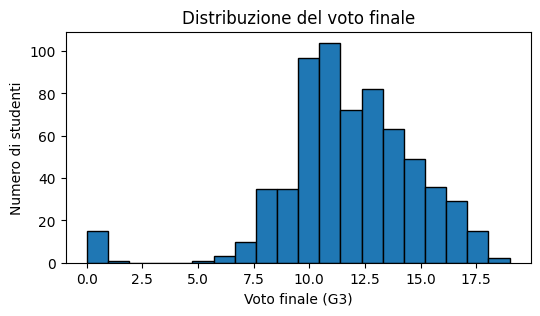

In [6]:
g3_mean = raw_dataset['G3'].mean()
g3_median = raw_dataset['G3'].median()
g3_mode = raw_dataset['G3'].mode()[0]
g3_std = raw_dataset['G3'].std()

print(f"Media di G3: {g3_mean}")
print(f"Mediana di G3: {g3_median}")
print(f"Moda di G3: {g3_mode}")
print(f"Deviazione standard di G3: {g3_std}")

# analisi della distribuzione:
plt.figure(figsize=(6, 3))
plt.hist(raw_dataset['G3'], bins=20, edgecolor='black')
plt.xlabel('Voto finale (G3)')
plt.ylabel('Numero di studenti')
plt.title('Distribuzione del voto finale')
plt.show()


Dall’analisi emerge che:

- La maggior parte degli studenti ottiene un voto finale compreso tra 10 e 15.

- I voti estremamente bassi (0–2) e molto alti (18–20) risultano rari.

- La moda della distribuzione si concentra attorno a 11, indicando il voto più frequente.


Successivamente si passa alla fase di selezione delle variabili più rilevanti per la predizione di G3. L’obiettivo è escludere le variabili meno informative o ridondanti, al fine di semplificare il modello e migliorarne l’efficacia predittiva.

Per fare ciò:

- Si calcola il coefficiente di correlazione di Pearson tra G3 e le variabili numeriche, per individuare quelle più associate in modo lineare alla variabile target.

- Per le variabili categoriche, si utilizza la mutua informazione, una misura capace di catturare anche relazioni non lineari con G3.

Soglie utilizzate:

- Correlazione di Pearson (≥ 0.2): La soglia di 0.2 è stata scelta perché rappresenta una correlazione moderata, sufficiente a suggerire una relazione lineare significativa con G3.

- Mutua informazione (> 0.02): La soglia di 0.02 consente di individuare anche variabili categoriche con effetti deboli ma potenzialmente rilevanti, specie in contesti non lineari.

In [7]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder

# Separazione delle variabili numeriche e categoriche
numeric_df = raw_dataset.select_dtypes(include=[np.number])
categorical_df = raw_dataset.select_dtypes(include=["object"])

# Calcolo della correlazione con G3
correlation_with_g3 = numeric_df.corr()["G3"].drop("G3")

# Soglia di selezione
relevant_numeric_features = correlation_with_g3[correlation_with_g3.abs() >= 0.2].sort_values(ascending=False)

# Codifica LabelEncoder per ogni colonna categorica
encoded_cat = categorical_df.apply(LabelEncoder().fit_transform)

# Calcolo della mutua informazione
mi_scores = mutual_info_regression(encoded_cat, raw_dataset["G3"], discrete_features=True)
mi_series = pd.Series(mi_scores, index=categorical_df.columns)

# Seleziona le variabili categoriche con MI > 0.02 (soglia regolabile)
relevant_categorical_features = mi_series[mi_series > 0.02].sort_values(ascending=False)

# RISULTATI FINALI

print("Variabili numeriche rilevanti (|correlazione Pearson| ≥ 0.2):")
print(relevant_numeric_features, "\n")

print("Variabili categoriche rilevanti (mutua informazione > 0.02):")
print(relevant_categorical_features)

# CREAZIONE NUOVO DATASET FILTRATO

selected_columns = list(relevant_numeric_features.index) + list(relevant_categorical_features.index) + ["G3"]
filtered_dataset = raw_dataset[selected_columns].copy()


Variabili numeriche rilevanti (|correlazione Pearson| ≥ 0.2):
G2           0.918548
G1           0.826387
studytime    0.249789
Medu         0.240151
Fedu         0.211800
Dalc        -0.204719
failures    -0.393316
Name: G3, dtype: float64 

Variabili categoriche rilevanti (mutua informazione > 0.02):
school    0.079874
higher    0.066850
reason    0.036267
sex       0.035386
famsup    0.023144
dtype: float64


# Encoding delle variabili categoriche

Dopo aver identificato le variabili più influenti, costruisco un nuovo dataset che include solo le feature selezionate. Prima di passare alla fase di modellazione, è necessario eseguire l’encoding delle variabili categoriche, trasformandole in una forma numerica adatta all’addestramento del modello di machine learning.

In [8]:
from sklearn.preprocessing import LabelEncoder

# Encoding e forzatura del tipo
for feature in filtered_dataset.select_dtypes(include='object').columns:
    le = LabelEncoder()
    filtered_dataset[feature] = le.fit_transform(filtered_dataset[feature]).astype(int)

print(filtered_dataset.dtypes)


G2           int64
G1           int64
studytime    int64
Medu         int64
Fedu         int64
Dalc         int64
failures     int64
school       int64
higher       int64
reason       int64
sex          int64
famsup       int64
G3           int64
dtype: object


# Train e Test Split

In [9]:
from sklearn.model_selection import train_test_split

# Separa le feature (X) dal target (y)
X = filtered_dataset.drop('G3', axis=1)
y = filtered_dataset['G3']

# Dividi i dati in set di training e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Predizione

Dopo aver preprocessato il dataset e selezionato le variabili più rilevanti tramite correlazione di Pearson e mutua informazione,  vengono addestrati due modelli di regressione: Random Forest e Support Vector Regressor (SVR).

Per ciascuno di essi viene effettuata una validazione degli iperparametri utilizzando la tecnica di RandomizedSearchCV con cross-validation a 5 fold, per garantire una valutazione robusta e coerente.

Per quanto riguarda Random Forest, ho scelto di validare i seguenti iperparametri:

- n_estimators: il numero di alberi, che influisce sulla stabilità del modello.

- max_depth: la profondità massima degli alberi, che regola la complessità del modello e il rischio di overfitting.

- min_samples_split e min_samples_leaf: che evitano di generare rami troppo piccoli e instabili.

- max_features: il numero di feature considerate a ogni split, utile per controllare la varianza.

Nel caso del Support Vector Regressor, ho validato:

- kernel: per esplorare sia approcci lineari che non lineari (es. RBF).

- C: il parametro di penalizzazione per gli errori, che controlla il compromesso tra bias e varianza.

- gamma: che regola l'influenza di ciascun punto (con kernel RBF).

- epsilon: che definisce la larghezza del margine all’interno del quale l’errore non è penalizzato.

Viene usato RandomizedSearchCV al posto della più tradizionale Grid Search per ridurre il tempo di calcolo quando lo spazio degli iperparametri è ampio.


# Random Forest

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

# Griglia degli iperparametri per Random Forest
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Istanza di RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=100,
    scoring=make_scorer(r2_score),
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Addestramento del modello con iperparametri ottimali
rf_random.fit(X_train, y_train)

# Migliori iperparametri trovati
print("Migliori iperparametri:", rf_random.best_params_)

# Valutazione sul test set
best_rf_model = rf_random.best_estimator_
y_pred = best_rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Migliori iperparametri: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}
Mean Squared Error (MSE): 1.7202342001922102
R-squared (R2): 0.8235967695975319


# Support Vector Regression (SVR)

In [11]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Scaling dei dati
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Griglia degli iperparametri per SVR
param_dist_svr = {
    'kernel': ['rbf', 'linear'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.01, 0.1, 0.5, 1]
}

# Istanza di RandomizedSearchCV
svr_random = RandomizedSearchCV(
    estimator=SVR(),
    param_distributions=param_dist_svr,
    n_iter=50,
    scoring=make_scorer(r2_score),
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Addestramento del modello con iperparametri ottimali
svr_random.fit(X_train_scaled, y_train)

# Migliori iperparametri trovati
print("Migliori iperparametri per SVR:", svr_random.best_params_)

# Valutazione sul test set
best_svr_model = svr_random.best_estimator_
y_pred_svr = best_svr_model.predict(X_test_scaled)
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"Mean Squared Error (MSE) - SVR: {mse_svr}")
print(f"R-squared (R2) - SVR: {r2_svr}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Migliori iperparametri per SVR: {'kernel': 'linear', 'gamma': 'scale', 'epsilon': 1, 'C': 100}
Mean Squared Error (MSE) - SVR: 1.364989420158841
R-squared (R2) - SVR: 0.8600257202453556


In [12]:
# Confronta le prestazioni di SVR con Random Forest
print("\nConfronto delle prestazioni:")
print(f"Random Forest - MSE: {mse}, R2: {r2}")
print(f"SVR - MSE: {mse_svr}, R2: {r2_svr}")


Confronto delle prestazioni:
Random Forest - MSE: 1.7202342001922102, R2: 0.8235967695975319
SVR - MSE: 1.364989420158841, R2: 0.8600257202453556


Come metrica principale di valutazione fra i due modelli viene utilizzato il R² (R-squared), che indica quanta parte della varianza dei voti finali (G3) è spiegata dal modello. In aggiunta, viene considerato il Mean Squared Error (MSE) come metrica secondaria per monitorare l’ampiezza degli errori.

I risultati ottenuti sui dati di test sono i seguenti:

- Random Forest:
  - MSE = 1.70,
  - R² = 0.82

- SVR:
  - MSE = 1.36
  - R² = 0.86

Il modello SVR ottiene prestazioni superiori rispetto a Random Forest, con un errore quadratico medio più basso e un R² più elevato.
Questo indica una migliore accuratezza e capacità esplicativa da parte di SVR sul test set.



# Valutazione finale

Dopo l’addestramento, la performance del modello SVR viene valutata anche graficamente.

Il primo grafico confronta i valori reali e quelli predetti del voto finale (G3): si osserva una chiara tendenza positiva, segno di una buona correlazione tra le due variabili. Tuttavia, i punti non sono perfettamente allineati lungo la diagonale ideale (linea rossa), il che evidenzia una certa dispersione, con errori maggiori in alcuni casi specifici.

Per un'analisi più approfondita, viene esaminata la distribuzione dei residui (differenza tra voto reale e voto predetto). Dall’istogramma emerge che:

- I residui sono fortemente concentrati attorno allo zero, indicando che le previsioni sono mediamente accurate;

- La distribuzione presenta una forma quasi normale, con una lieve asimmetria a destra.

- La media dei residui è prossima a zero, come mostrato dalla linea rossa verticale, un segnale positivo che indica l’assenza di bias sistematici: il modello non tende né a sovrastimare né a sottostimare i voti.


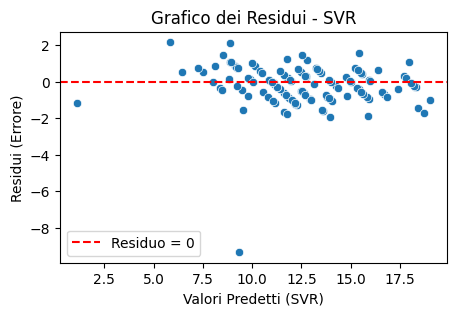

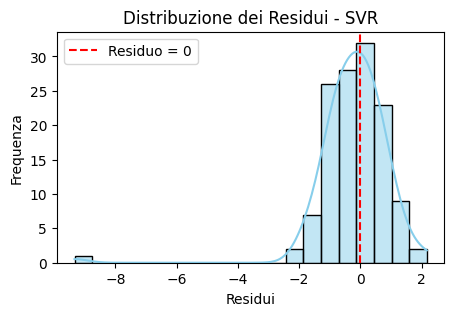

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcolo dei residui
residuals = y_test - y_pred_svr

# Grafico dei residui vs predetti
plt.figure(figsize=(5, 3))
sns.scatterplot(x=y_pred_svr, y=residuals)
plt.axhline(0, color='red', linestyle='--', label='Residuo = 0')
plt.xlabel('Valori Predetti (SVR)')
plt.ylabel('Residui (Errore)')
plt.title('Grafico dei Residui - SVR')
plt.legend()
plt.show()

# Distribuzione dei residui
plt.figure(figsize=(5, 3))
sns.histplot(residuals, bins=20, kde=True, color='skyblue')
plt.axvline(0, color='red', linestyle='--', label='Residuo = 0')
plt.xlabel('Residui')
plt.ylabel('Frequenza')
plt.title('Distribuzione dei Residui - SVR')
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Importanza delle feature (SVR - Permutation Importance):
      Feature  Importance
0          G2    2.742742
3        Medu    0.004897
4        Fedu    0.003677
5        Dalc    0.001202
9      reason    0.000751
11     famsup   -0.000615
10        sex   -0.003875
8      higher   -0.004999
6    failures   -0.014061
2   studytime   -0.015452
7      school   -0.018428
1          G1   -0.994642


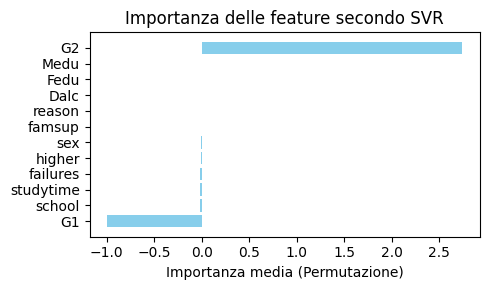

In [14]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Calcola l'importanza delle feature con permutation importance
result = permutation_importance(
    best_svr_model,
    X_test,
    y_test,
    n_repeats=30,
    random_state=42,
    n_jobs=-1
)

# Crea un DataFrame
feature_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

# Stampa le feature
print("Importanza delle feature (SVR - Permutation Importance):")
print(feature_importance)

# Grafico a barre
plt.figure(figsize=(5, 3))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Feature più importanti in cima
plt.xlabel('Importanza media (Permutazione)')
plt.title('Importanza delle feature secondo SVR')
plt.tight_layout()
plt.show()


L'analisi della permutation importance conferma che il fattore predominante nella previsione del voto finale (G3) da parte del modello SVR è il voto del secondo periodo (G2). Le altre feature selezionate, pur avendo mostrato una certa rilevanza statistica nelle fasi iniziali (correlazione/mutua informazione), non apportano un miglioramento significativo alle predizioni del modello una volta che G2 è incluso. Questo suggerisce che per questo specifico modello e set di dati, la performance precedente e più recente (G2) è l'informazione chiave, rendendo l'impatto incrementale delle altre variabili molto limitato.

# Considerazioni finali

In conclusione, questo studio dimostra la fattibilità e l'utilità di applicare tecniche di machine learning per prevedere il successo accademico, fornendo uno strumento potenziale per supportare decisioni basate sui dati nel sistema educativo e promuovere il successo degli studenti.